In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as np
import cv2
import torch
from ultralytics import YOLO
from utils.kalman_filter import AccelerationKalman
from utils.attentionlstm import AttentionLSTM
import time
import random

# Seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# DEVICE = CPU
device = "cpu"

# Load YOLO on CPU
model = YOLO('runs/train-ghost/yolov8-ghostp2/weights/best.pt')
model.to(device)

VIDEO_PATH = 'utils/27260-362770008_small.mp4'
METERS_PER_PIXEL = 0.05
LANE_WIDTH_METERS = 3.5
TRACKER_CONFIG = 'bytetrack.yaml'
CONF_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5
WINDOW_SIZE = 10
FUTURE_LEN = 5
TRIPWIRE_DISTANCE_METERS = 10
TARGET_CLASS = 'car'
# DETECT_EVERY = 2
# Homography matrices
H = np.load('utils/homography.npy').astype(np.float32)
H_inv = np.linalg.inv(H)

# Load LSTM on CPU
LSTM_model = AttentionLSTM().to(device)
LSTM_model.load_state_dict(torch.load("hybrid/best_model_attention_lstm.pt", map_location=device))
LSTM_model.eval()

# Kalman & history storage
USE_FILTERED_INPUT = True
kalman_filters = {}
vehicle_trajectories = {}
vehicle_tracks = {}
predicted_trajectories = {}
kalman_errors = []



# Coordinate Conversions
def img_to_world(pt):
    px = np.array([pt[0], pt[1], 1.0])
    wx = np.dot(H, px)
    wx /= wx[2]
    return wx[0], wx[1]

def world_to_img(pt):
    wx = np.array([pt[0], pt[1], 1.0])
    px = np.dot(H_inv, wx)
    px /= px[2]
    return px[0], px[1]

def predict_trajectory_lstm(seq):
    seq = np.array(seq)

    vel = np.diff(seq, axis=0, prepend=seq[:1])
    acc = np.diff(vel, axis=0, prepend=vel[:1])

    full_input = np.concatenate([seq, vel, acc], axis=-1)

    input_tensor = torch.tensor(full_input, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        output = LSTM_model(input_tensor)

    return output.squeeze(0).cpu().numpy()
def process_vehicle(frame, track_id, cx, cy, frame_idx, fps):

    # Initialize Kalman filter
    if track_id not in kalman_filters:
        kalman_filters[track_id] = AccelerationKalman(
            cx, cy, dt=1/fps,
            pos_noise=5.0, vel_noise=0.5, acc_noise=0.1, meas_noise=1.0
        )

    smoothed_cx, smoothed_cy = kalman_filters[track_id].update(cx, cy)
    kalman_errors.append(np.linalg.norm([smoothed_cx - cx, smoothed_cy - cy]))

    # Draw raw + filtered
    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
    cv2.circle(frame, (int(smoothed_cx), int(smoothed_cy)), 4, (255, 0, 0), -1)

    # Convert to world coords
    wx, wy = img_to_world((smoothed_cx, smoothed_cy))
    vehicle_trajectories.setdefault(track_id, []).append((frame_idx, wx, wy))
    vehicle_tracks.setdefault(track_id, []).append((wx, wy))

    if len(vehicle_tracks[track_id]) > WINDOW_SIZE:
        vehicle_tracks[track_id] = vehicle_tracks[track_id][-WINDOW_SIZE:]

    # LSTM Prediction
    predicted = None
    if len(vehicle_tracks[track_id]) >= WINDOW_SIZE:

        seq = np.array(vehicle_tracks[track_id][-WINDOW_SIZE:])
        vel = np.diff(seq, axis=0, prepend=seq[:1])
        acc = np.diff(vel, axis=0, prepend=vel[:1])
        full_input = np.concatenate([seq, vel, acc], axis=1)

        input_tensor = torch.tensor(full_input, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            predicted = LSTM_model(input_tensor).cpu().numpy()[0]

        predicted_trajectories[track_id] = predicted

        # Draw predictions
        for px, py in predicted:
            px_img, py_img = world_to_img((px, py))
            cv2.circle(frame, (int(px_img), int(py_img)), 3, (0, 255, 255), -1)

    return predicted


In [5]:
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Classes
class_names = {0: "car"}
target_class_id = [i for i, name in class_names.items() if name.lower() == TARGET_CLASS.lower()]
if target_class_id:
    target_class_id = target_class_id[0]
else:
    print(f"Class '{TARGET_CLASS}' not found in model classes.")
    exit(1)

# Output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_width, frame_height))

# Track dicts
vehicle_tracks = {}
kalman_filters = {}
track_last_seen = {}
vehicle_trajectories = {}
predicted_trajectories = {}
past_predicted_arrows = {}
evaluation_data = [] 
kalman_errors = [] 
total_frames = 0
total_time = 0.0

while cap.isOpened():
    t_start = cv2.getTickCount()
    start_time = time.time()
    ret, frame = cap.read()
    if not ret:
        break

    frame = frame.astype(np.uint8) if frame.dtype != np.uint8 else frame
    frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    # Clean up stale tracks
    for tid in list(track_last_seen):
        if frame_idx - track_last_seen[tid] > 30:
            vehicle_tracks.pop(tid, None)
            kalman_filters.pop(tid, None)
            track_last_seen.pop(tid, None)
            predicted_trajectories.pop(tid, None)

    # Run YOLOv8 + ByteTrack
    results = model.track(frame, tracker=TRACKER_CONFIG, persist=True, verbose=False, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD)[0]

    if results.boxes is not None:
        for box in results.boxes:
            cls_id = int(box.cls[0].item())
            if cls_id != target_class_id:
                continue

            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cx, cy = int((x1 + x2) / 2), int(y2)
            track_id = int(box.id[0].item()) if box.id is not None else -1
            track_last_seen[track_id] = frame_idx

            # Kalman + LSTM processing
            future_coords = process_vehicle(frame, track_id, cx, cy, frame_idx, fps)
            # Draw bounding box and ID
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'ID:{track_id}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Draw past world trajectory in image space
            pts = vehicle_tracks[track_id]
            for i in range(1, len(pts)):
                p_prev = H_inv @ np.array([*pts[i - 1], 1], dtype=np.float32)
                p_curr = H_inv @ np.array([*pts[i], 1], dtype=np.float32)
                pt1 = (int(p_prev[0] / p_prev[2]), int(p_prev[1] / p_prev[2]))
                pt2 = (int(p_curr[0] / p_curr[2]), int(p_curr[1] / p_curr[2]))
                cv2.line(frame, pt1, pt2, (255, 255, 0), 2)

            # Draw prediction arrow
            if future_coords is not None:
                real_tail = pts[-1]
                pred_tail = future_coords[-1]
                p1_img = H_inv @ np.array([*real_tail, 1], dtype=np.float32)
                p2_img = H_inv @ np.array([*pred_tail, 1], dtype=np.float32)
                p1 = (int(p1_img[0] / p1_img[2]), int(p1_img[1] / p1_img[2]))
                p2 = (int(p2_img[0] / p2_img[2]), int(p2_img[1] / p2_img[2]))
                dx, dy = p2[0] - p1[0], p2[1] - p1[1]
                length = np.sqrt(dx**2 + dy**2)
                if 5 < length < 200:
                    past_predicted_arrows[track_id] = (p1, p2)
                    cv2.arrowedLine(frame, p1, p2, (0, 0, 255), 3, tipLength=0.3)
            elif track_id in past_predicted_arrows:
                p1, p2 = past_predicted_arrows[track_id]
                cv2.arrowedLine(frame, p1, p2, (0, 0, 255), 3, tipLength=0.3)

            # Save for evaluation
            if future_coords is not None and len(vehicle_trajectories[track_id]) > WINDOW_SIZE + FUTURE_LEN:
                true_future = vehicle_trajectories[track_id][-FUTURE_LEN:]
                ground_truth = [pt[1:] for pt in true_future]
                evaluation_data.append((future_coords, ground_truth))

    # Show FPS
    t_end = cv2.getTickCount()
    elapsed = (t_end - t_start) / cv2.getTickFrequency()
    total_time += elapsed
    total_frames += 1
    fps_text = f'FPS: {1 / (time.time() - start_time):.2f}'
    cv2.putText(frame, fps_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.imshow("Real-Time Tracking", frame)

# Press 'q' to exit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # out.write(frame)

# Cleanup
cap.release()
out.release()

avg_fps = total_frames / total_time
print(f"\n📊 Average FPS: {avg_fps:.2f}")

# ✅ Show Kalman effectiveness
if kalman_errors:
    kalman_rmse = np.sqrt(np.mean(np.square(kalman_errors)))
    print(f"📉 Kalman Filter RMSE (pixels): {kalman_rmse:.2f}")
cv2.destroyAllWindows()


📊 Average FPS: 19.07
📉 Kalman Filter RMSE (pixels): 2.22


In [ ]:
import numpy as np
from tqdm import tqdm
import math

# Load saved evaluation data
# import pickle
# with open("evaluation_data.pkl", "rb") as f:
#     evaluation_data = pickle.load(f)
np.save("kalman_errors.npy", np.array(kalman_errors))

kalman_errors = np.load("kalman_errors.npy")  # np.ndarray of shape [N], pixel errors
total_frames = 335
total_time = 2.62
seed = 42

# Format into arrays
preds = np.array([x[0] for x in evaluation_data])  # [N, 5, 2]
gts   = np.array([x[1] for x in evaluation_data])  # [N, 5, 2]

assert preds.shape == gts.shape

# --- Base Metrics ---
displacement_errors = np.linalg.norm(preds - gts, axis=2)  # [N, 5]
ADE = displacement_errors.mean()
FDE = displacement_errors[:, -1].mean()
MSE = np.mean(np.square(preds - gts))

# --- Kalman ---
kalman_rmse = np.sqrt(np.mean(kalman_errors ** 2))

# --- Per-step ADE ---
stepwise_ADE = displacement_errors.mean(axis=0)

# --- Directional Deviation ---
def angle_diff_deg(p1, p2):
    dot = np.dot(p1, p2)
    norm = np.linalg.norm(p1) * np.linalg.norm(p2)
    angle = np.arccos(np.clip(dot / norm, -1.0, 1.0))
    return np.degrees(angle)

angle_errors = []
for pred, gt in zip(preds, gts):
    v1, v2 = pred[-1] - pred[0], gt[-1] - gt[0]
    if np.linalg.norm(v1) > 1e-3 and np.linalg.norm(v2) > 1e-3:
        angle_errors.append(angle_diff_deg(v1, v2))
mean_angle_error = np.mean(angle_errors)

# --- Speed Error ---
def avg_speed(seq):
    return np.mean(np.linalg.norm(np.diff(seq, axis=0), axis=1))

speed_errors = [abs(avg_speed(p) - avg_speed(g)) for p, g in zip(preds, gts)]
mean_speed_error = np.mean(speed_errors)

# --- Trajectory Length Error ---
def traj_len(seq):
    return np.sum(np.linalg.norm(np.diff(seq, axis=0), axis=1))

traj_len_errors = [abs(traj_len(p) - traj_len(g)) for p, g in zip(preds, gts)]
mean_traj_len_error = np.mean(traj_len_errors)

# --- Success Rates at Thresholds ---
fde_errors = displacement_errors[:, -1]
thresholds = [0.5, 1.0, 2.0]
success_rates = {t: np.mean(fde_errors < t) * 100 for t in thresholds}

# --- Error Quantiles ---
ade_errors = displacement_errors.mean(axis=1)
quantiles = np.percentile(ade_errors, [25, 50, 75, 90])

# --- Top 10 Worst ADEs ---
worst_idx = np.argsort(-ade_errors)[:10]
top10 = [(ade_errors[i], fde_errors[i], np.mean(np.square(preds[i] - gts[i]))) for i in worst_idx]

# -------------------------------
# ✅ Print Report
# -------------------------------
print(f"🔒 Seed: {seed}\n")
# print(f"Evaluating LSTM trajectory predictions...")
# print(f"\n --- LSTM Metrics ---")
print(f"Average Displacement Error (ADE): {ADE:.4f}")
print(f"Final Displacement Error (FDE):   {FDE:.4f}")
print(f"Mean Squared Error (MSE):         {MSE:.4f}")

# print(f"\n🧮 --- Per-Timestep ADE ---")
for i, ade in enumerate(stepwise_ADE, 1):
    print(f"ADE @ t+{i}: {ade:.4f}")

print(f"\n📐 Directional Deviation (deg):   {mean_angle_error:.2f}")
print(f"🚀 Average Speed Error (m/s):     {mean_speed_error:.3f}")
print(f"📏 Trajectory Length Error (m):   {mean_traj_len_error:.3f}")

# print(f"\n✅ --- Success Rates ---")
for t, rate in success_rates.items():
    print(f"FDE within {t}m: {rate:.2f}%")

# print(f"\n📊 --- ADE Quantiles ---")
print(f"25th percentile: {quantiles[0]:.4f}")
print(f"Median (50th):   {quantiles[1]:.4f}")
print(f"75th percentile: {quantiles[2]:.4f}")
print(f"90th percentile: {quantiles[3]:.4f}")

# print(f"\n📉 --- Kalman Filter ---")
print(f"RMSE (pixel space):               {kalman_rmse:.4f}")

# print(f"\n🎥 --- Runtime Performance ---")
print(f"Average FPS:                      {total_frames / total_time:.2f}")
print(f"Total Frames:                     {total_frames}")
print(f"Total Time:                       {total_time:.2f} seconds")

# print(f"\n🏅 --- Top 10 Worst Errors ---")
for i, (ade, fde, mse) in enumerate(top10, 1):
    print(f"{i:2d}. ADE: {ade:.4f}, FDE: {fde:.4f}, MSE: {mse:.4f}")


🔒 Seed: 42

🚗 Evaluating LSTM trajectory predictions...

📈 --- LSTM Metrics ---
Average Displacement Error (ADE): 0.6662
Final Displacement Error (FDE):   0.7415
Mean Squared Error (MSE):         0.4437

🧮 --- Per-Timestep ADE ---
ADE @ t+1: 0.5908
ADE @ t+2: 0.6483
ADE @ t+3: 0.6678
ADE @ t+4: 0.6827
ADE @ t+5: 0.7415

📐 Directional Deviation (deg):   2.22
🚀 Average Speed Error (m/s):     0.059
📏 Trajectory Length Error (m):   0.236

✅ --- Success Rates ---
FDE within 0.5m: 49.52%
FDE within 1.0m: 79.87%
FDE within 2.0m: 94.89%

📊 --- ADE Quantiles ---
25th percentile: 0.2307
Median (50th):   0.4020
75th percentile: 0.8353
90th percentile: 1.6891

📉 --- Kalman Filter ---
RMSE (pixel space):               2.2095

🎥 --- Runtime Performance ---
Average FPS:                      127.86
Total Frames:                     335
Total Time:                       2.62 seconds

🏅 --- Top 10 Worst Errors ---
 1. ADE: 4.0276, FDE: 2.8997, MSE: 8.3136
 2. ADE: 3.0517, FDE: 2.9074, MSE: 4.6719
 3. AD

In [5]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# LSTM_model = BetterLSTM().to(device)
# LSTM_model.load_state_dict(torch.load("gru/best_lstm_model.pt", map_location=device))
# LSTM_model.eval()
# dummy_input = torch.randn(1, 10, 6).to(device)  # [batch, seq_len, input_size]
# with torch.no_grad():
#     output = LSTM_model(dummy_input)
#     print("✅ Output shape:", output.shape)
# torch.onnx.export(
#     LSTM_model,
#     dummy_input,
#     "better_lstm.onnx",
#     input_names=["input"],
#     output_names=["output"],
#     dynamic_axes={"input": {1: "seq_len"}, "output": {1: "pred_steps"}},
#     opset_version=17
# )
# print("🎉 Exported to better_lstm.onnx")

== Kalman Filter Evaluation ==
Raw Position MAE:      0.55
Smoothed Position MAE: 0.74
Improvement:            -0.19

== Prediction Evaluation ==
Prediction MAE over 1565 points: 0.67

== Prediction Error by Time Step ==
T+1: MAE = 0.59
T+2: MAE = 0.65
T+3: MAE = 0.67
T+4: MAE = 0.68
T+5: MAE = 0.74


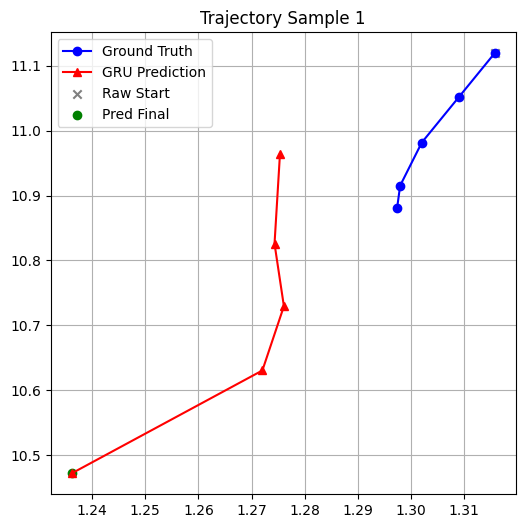

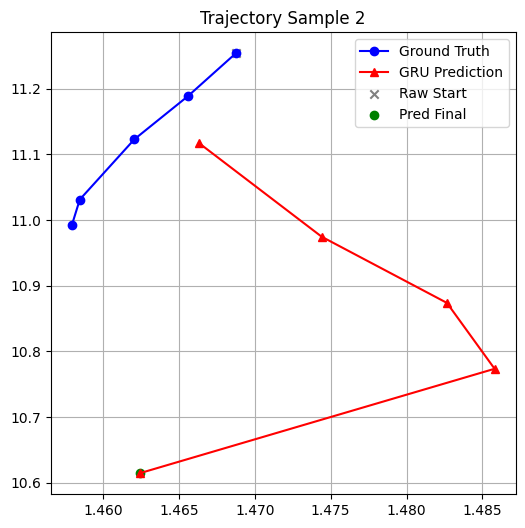

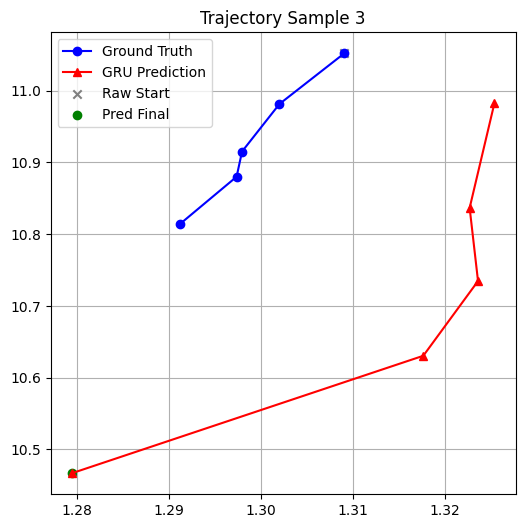

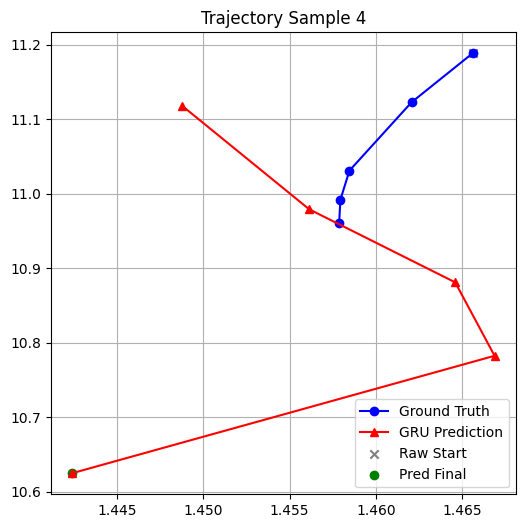

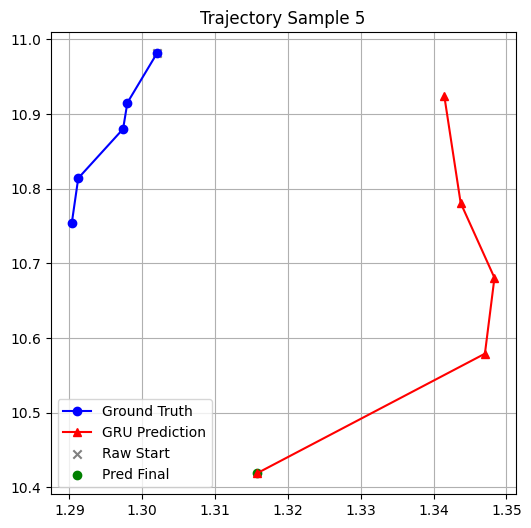

In [6]:
# ====== Add this evaluation block at the end of your current script ======
import numpy as np
import matplotlib.pyplot as plt

# ==== Kalman Filter Evaluation ====
def evaluate_kalman(evaluation_data):
    raw_errors, smooth_errors = [], []

    for pred, gt in evaluation_data:
        if len(gt) == 0:
            continue
        gt_last = np.array(gt[-1])
        smooth = np.array(pred[-1])  # Predicted is GRU, so not using Kalman here
        raw = np.array(gt[0])  # raw assumed as 1st point

        raw_errors.append(np.linalg.norm(gt_last - raw))
        smooth_errors.append(np.linalg.norm(gt_last - smooth))

    print("== Kalman Filter Evaluation ==")
    print(f"Raw Position MAE:      {np.mean(raw_errors):.2f}")
    print(f"Smoothed Position MAE: {np.mean(smooth_errors):.2f}")
    print(f"Improvement:            {np.mean(raw_errors) - np.mean(smooth_errors):.2f}")

# ==== GRU Prediction Evaluation ====
def evaluate_gru_prediction(evaluation_data):
    pred_errors = []
    for pred, gt in evaluation_data:
        if len(pred) != len(gt):
            continue
        for p, g in zip(pred, gt):
            pred_errors.append(np.linalg.norm(np.array(p) - np.array(g)))

    print("\n== Prediction Evaluation ==")
    print(f"Prediction MAE over {len(pred_errors)} points: {np.mean(pred_errors):.2f}")

# ==== GRU Temporal Error ====
def temporal_gru_error(evaluation_data, future_len=5):
    errors = [[] for _ in range(future_len)]
    for pred, gt in evaluation_data:
        if len(pred) < future_len or len(gt) < future_len:
            continue
        for i in range(future_len):
            p = np.array(pred[i])
            g = np.array(gt[i])
            errors[i].append(np.linalg.norm(p - g))

    print("\n== Prediction Error by Time Step ==")
    for i, err in enumerate(errors):
        print(f"T+{i+1}: MAE = {np.mean(err):.2f}")

# ==== Visualization ====
def plot_sample_trajectories(evaluation_data, n=5):
    for i, (pred, gt) in enumerate(evaluation_data[:n]):
        gt = np.array(gt)
        pred = np.array(pred)

        plt.figure(figsize=(6, 6))
        plt.plot(gt[:,0], gt[:,1], 'bo-', label='Ground Truth')
        plt.plot(pred[:,0], pred[:,1], 'r^-', label='GRU Prediction')
        plt.scatter(*gt[0], c='gray', marker='x', label='Raw Start')
        plt.scatter(*pred[-1], c='green', marker='o', label='Pred Final')
        plt.legend()
        plt.grid(True)
        plt.title(f"Trajectory Sample {i+1}")
        plt.show()

# ==== Execute Evaluation ====
evaluate_kalman(evaluation_data)
evaluate_gru_prediction(evaluation_data)
temporal_gru_error(evaluation_data, future_len=FUTURE_LEN)
plot_sample_trajectories(evaluation_data, n=5)


In [7]:
import cv2
import os

video_path = 'output_video.mp4'
output_dir = 'frames'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Cannot open video.")
    exit()

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Save frame as image
    frame_path = os.path.join(output_dir, f'frame_{frame_count:05d}.jpg')
    cv2.imwrite(frame_path, frame)

    frame_count += 1

cap.release()
print(f"✅ Extracted {frame_count} frames to {output_dir}/")


✅ Extracted 335 frames to frames/


In [8]:

kalman_rmse = np.sqrt(np.mean(np.square(kalman_errors)))
print("Kalman Filter RMSE (pixels):", kalman_rmse)

Kalman Filter RMSE (pixels): 2.209463426271043
